# 2: Club Data Cleaning and Scoring

This notebook continues the data preparation

The columns that I still need are `club number, members, new members, and member awards`. Member awards are not available directly but can be copy/pasted from the relevant award report. The others are in the Club Performance Report.

The columns I still need to calculate are `awards/member, new/renewing member ratio, and normalized versions of those and members`. I have already calculated lat/long. It's in the club_zips.csv file.

MinMaxScaler is imported from scikit learn for normalization.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler 

### Import the club numbers and zip code file

In [3]:
club_zips = pd.read_csv('../club_zips.csv')
club_zips.head()

,club_no,zip,lat,long
0,437,75237,32.663048,-96.875500
1,713,75206,32.833883,-96.772023
2,718,71101,32.507846,-93.744677
3,967,75024-3607,33.084829,-96.812687
4,1165,75201-6318,32.788745,-96.800411


### Import the file with members and goals
Most up to date Club Performance Report

In [4]:
club_members_raw = pd.read_csv('20210112_D50_Club_Performance.csv')
club_members_raw.head()

,District,Division,Area,Club Number,Club Name,Club Status,Mem. Base,Active Members,Goals Met,Level 1s,...,"Level 4s, Level 5s, or DTM award","Add. Level 4s, Level 5s, or DTM award",New Members,Add. New Members,Off. Trained Round 1,Off. Trained Round 2,Mem. dues on time Oct,Mem. dues on time Apr,Off. List On Time,Club Distinguished Status
0,50,E,11.0,5509.0,Twin Cities Club,Active,19.0,15.0,4.0,6.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,NaN
1,50,E,11.0,7036.0,University Club,Active,20.0,10.0,3.0,2.0,...,1.0,1.0,2.0,0.0,6.0,0.0,1.0,0.0,1.0,NaN
2,50,E,11.0,9682.0,200 Watt Speakers Club,Active,15.0,12.0,4.0,1.0,...,1.0,1.0,1.0,0.0,5.0,0.0,1.0,0.0,1.0,NaN
3,50,E,11.0,584009.0,Conquerors Club,Active,8.0,8.0,2.0,2.0,...,0.0,0.0,3.0,0.0,4.0,0.0,1.0,0.0,2.0,NaN
4,50,E,11.0,1100434.0,Solid Rock,Active,13.0,8.0,5.0,2.0,...,1.0,4.0,0.0,0.0,5.0,0.0,1.0,0.0,1.0,NaN


In [9]:
club_members = club_members_raw[['Club Number', 'Active Members', 'Goals Met', 
                                 'New Members', 'Add. New Members']].copy().dropna()
club_members.head()

,Club Number,Active Members,Goals Met,New Members,Add. New Members
0,5509.0,15.0,4.0,1.0,0.0
1,7036.0,10.0,3.0,2.0,0.0
2,9682.0,12.0,4.0,1.0,0.0
3,584009.0,8.0,2.0,3.0,0.0
4,1100434.0,8.0,5.0,0.0,0.0


In [10]:
club_members = club_members.astype(int)

In [11]:
club_members['new_members'] = club_members['New Members'] + club_members['Add. New Members']
club_members.head()

,Club Number,Active Members,Goals Met,New Members,Add. New Members,new_members
0,5509,15,4,1,0,1
1,7036,10,3,2,0,2
2,9682,12,4,1,0,1
3,584009,8,2,3,0,3
4,1100434,8,5,0,0,0


In [12]:
club_members.drop(columns = ['New Members', 'Add. New Members'], inplace=True)
club_members.rename(columns = {'Club Number': 'club_no',
                               'Active Members': 'current_members',
                               'Goals Met': 'goals'},
                   inplace = True)
club_members.head()

,club_no,current_members,goals,new_members
0,5509,15,4,1
1,7036,10,3,2
2,9682,12,4,1
3,584009,8,2,3
4,1100434,8,5,0


### Import the Member Awards

In [13]:
awards_raw = pd.read_csv('20201229_D50_Awards.csv')
awards_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Club    777 non-null    int64 
 1   Award   777 non-null    object
 2   Member  777 non-null    object
 3   Name    777 non-null    object
dtypes: int64(1), object(3)
memory usage: 24.4+ KB


In [14]:
awards = pd.DataFrame(awards_raw.groupby('Club').count()['Award'])
awards.reset_index(inplace=True)
awards.rename(columns = {'Club': 'club_no', 'Award':'awards'}, inplace=True)
awards.head()

,club_no,awards
0,437,19
1,718,9
2,1190,1
3,1207,11
4,1783,14


### Merge the data
- Dataframes: club_zips, club_members, awards ON club_no
- Double check the number of clubs

In [15]:
print(len(club_zips))
print(len(club_members))
print(len(awards))

221
207
129


It turns out, club_zips was based on an older report that had addresses. 207 is the current count though not all clubs have awards.

In [19]:
club_members_awards = club_members.merge(awards, how = 'left', on = 'club_no')
club_members_awards['awards'] = club_members_awards['awards'].fillna(0).astype(int)
club_members_awards.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207 entries, 0 to 206
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   club_no          207 non-null    int32
 1   current_members  207 non-null    int32
 2   goals            207 non-null    int32
 3   new_members      207 non-null    int32
 4   awards           207 non-null    int32
dtypes: int32(5)
memory usage: 5.7 KB


In [20]:
clubs = club_members_awards.merge(club_zips, how = 'inner', on = 'club_no')
clubs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196 entries, 0 to 195
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   club_no          196 non-null    int32  
 1   current_members  196 non-null    int32  
 2   goals            196 non-null    int32  
 3   new_members      196 non-null    int32  
 4   awards           196 non-null    int32  
 5   zip              196 non-null    object 
 6   lat              196 non-null    float64
 7   long             196 non-null    float64
dtypes: float64(2), int32(5), object(1)
memory usage: 10.0+ KB


In this instance, it appears we have some new clubs that were not in the address list. We'll drop those for now. Additionally, we need to fill the rest of the awards column with zeros.

It turns out we have some clubs with zero members. Let's drop those from our grouping.

In [14]:
clubs = clubs[clubs['current_members'] > 0]
clubs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168 entries, 0 to 203
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   area             168 non-null    int32  
 1   club_no          168 non-null    int32  
 2   current_members  168 non-null    int32  
 3   goals            168 non-null    int32  
 4   division         168 non-null    object 
 5   new_members      168 non-null    int32  
 6   awards           168 non-null    int32  
 7   zip              168 non-null    object 
 8   lat              168 non-null    float64
 9   long             168 non-null    float64
dtypes: float64(2), int32(6), object(2)
memory usage: 10.5+ KB


### Calculate New Columns
We need awards/member (participation), new/renewing member ratio (retention), and normalized versions of those.
We also need normalized variations from ideal membership of 25 and retention of 80%

In [15]:
clubs['participation'] = clubs['awards'] / clubs['current_members']
clubs['retention'] = (clubs['current_members'] - clubs['new_members']) / clubs['current_members']
clubs['member_variation'] = abs(clubs['current_members'] - 25)
clubs['retention_variation'] = abs(clubs['retention'] - 0.8)
clubs.head()

,area,club_no,current_members,goals,division,new_members,awards,zip,lat,long,participation,retention,member_variation,retention_variation
0,11,5509,15,4,E,1,9,75501,33.3672,-94.2356,0.6,0.933333,10,0.133333
1,11,7036,10,3,E,2,5,75501,33.3672,-94.2356,0.5,0.800000,15,0.000000
2,11,9682,12,4,E,1,6,71101,32.5072,-93.7444,0.5,0.916667,13,0.116667
3,11,584009,8,2,E,3,4,71110,32.5153,-93.6345,0.5,0.625000,17,0.175000
4,11,1100434,8,5,E,0,16,75501-6314,33.3672,-94.2356,2.0,1.000000,17,0.200000


In [16]:
# Check retention distribution
clubs.describe()

,area,club_no,current_members,goals,new_members,awards,lat,long,participation,retention,member_variation,retention_variation
count,168.000000,1.680000e+02,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
mean,42.327381,2.176800e+06,14.988095,2.583333,2.470238,4.529762,32.917483,-96.494536,0.323833,0.835997,11.464286,0.120900
std,20.263976,2.648719e+06,7.755229,1.980191,2.417317,4.703070,0.220601,0.766280,0.389206,0.143709,5.363318,0.085156
min,11.000000,4.370000e+02,1.000000,0.000000,0.000000,0.000000,32.286800,-96.897400,0.000000,0.285714,0.000000,0.000000
25%,24.000000,6.754750e+03,10.000000,1.000000,1.000000,0.000000,32.800975,-96.812800,0.000000,0.757500,8.000000,0.057143
50%,43.000000,9.950945e+05,13.000000,2.000000,2.000000,3.000000,32.959800,-96.754450,0.222222,0.873397,12.000000,0.109091
75%,61.000000,4.293647e+06,19.000000,4.000000,3.250000,8.000000,33.057800,-96.670900,0.500000,0.945175,15.000000,0.200000
max,76.000000,7.575630e+06,52.000000,8.000000,12.000000,21.000000,33.591100,-93.388200,2.500000,1.000000,27.000000,0.514286


Lastly, create normalized members, participation, and retention columns.

In [17]:
clubs['n_participation'] = MinMaxScaler().fit_transform(np.array(clubs['participation']).reshape(-1,1))
clubs['n_ret_var'] = MinMaxScaler().fit_transform(np.array(clubs['retention_variation']).reshape(-1,1))
clubs['n_mem_var'] = MinMaxScaler().fit_transform(np.array(clubs['member_variation']).reshape(-1,1))
clubs.head()

,area,club_no,current_members,goals,division,new_members,awards,zip,lat,long,participation,retention,member_variation,retention_variation,n_participation,n_ret_var,n_mem_var
0,11,5509,15,4,E,1,9,75501,33.3672,-94.2356,0.6,0.933333,10,0.133333,0.24,0.259259,0.370370
1,11,7036,10,3,E,2,5,75501,33.3672,-94.2356,0.5,0.800000,15,0.000000,0.20,0.000000,0.555556
2,11,9682,12,4,E,1,6,71101,32.5072,-93.7444,0.5,0.916667,13,0.116667,0.20,0.226852,0.481481
3,11,584009,8,2,E,3,4,71110,32.5153,-93.6345,0.5,0.625000,17,0.175000,0.20,0.340278,0.629630
4,11,1100434,8,5,E,0,16,75501-6314,33.3672,-94.2356,2.0,1.000000,17,0.200000,0.80,0.388889,0.629630


### Create an aggregate quality score
Since we want to maximize participation and minimize retention and membership variation, add the former, subtract the latter, and then normalize the result. Newly chartered clubs that don't have participation or retention numbers could be assigned the average quality score.

In [18]:
clubs['raw_quality'] = clubs.n_participation - clubs.n_ret_var - clubs.n_mem_var
clubs['n_quality'] = MinMaxScaler().fit_transform(np.array(clubs['raw_quality']).reshape(-1,1))
clubs.head()

,area,club_no,current_members,goals,division,new_members,awards,zip,lat,long,participation,retention,member_variation,retention_variation,n_participation,n_ret_var,n_mem_var,raw_quality,n_quality
0,11,5509,15,4,E,1,9,75501,33.3672,-94.2356,0.6,0.933333,10,0.133333,0.24,0.259259,0.370370,-0.389630,0.677709
1,11,7036,10,3,E,2,5,75501,33.3672,-94.2356,0.5,0.800000,15,0.000000,0.20,0.000000,0.555556,-0.355556,0.695792
2,11,9682,12,4,E,1,6,71101,32.5072,-93.7444,0.5,0.916667,13,0.116667,0.20,0.226852,0.481481,-0.508333,0.614715
3,11,584009,8,2,E,3,4,71110,32.5153,-93.6345,0.5,0.625000,17,0.175000,0.20,0.340278,0.629630,-0.769907,0.475900
4,11,1100434,8,5,E,0,16,75501-6314,33.3672,-94.2356,2.0,1.000000,17,0.200000,0.80,0.388889,0.629630,-0.218519,0.768516


Notice that even clubs with 8 members can have a higher score if they have high participation rates. Total members doesn't tell the whole story if none of the members are getting awards.

For example, club 3812934 got a perfect quality score of 1.0 with 22 members, 5 new members, and 21 awards.

In [19]:
clubs[clubs['club_no'] == 3812934]

,area,club_no,current_members,goals,division,new_members,awards,zip,lat,long,participation,retention,member_variation,retention_variation,n_participation,n_ret_var,n_mem_var,raw_quality,n_quality
28,16,3812934,22,8,E,5,21,75070-2908,33.1709,-96.6925,0.954545,0.772727,3,0.027273,0.381818,0.05303,0.111111,0.217677,1.0


Now we have all the data we need to group these clubs into balanced areas. Export the result.

In [20]:
# Save it for later import
clubs.to_csv('clubs_cleaned.csv', index=False)

We'll also need a file with only the club number and normalized quality scores for the genetic algorithm. We can add the locations back in later.

In [21]:
clubs_to_realign = clubs[['club_no', 'n_quality']].copy()
clubs_to_realign.head()

,club_no,n_quality
0,5509,0.677709
1,7036,0.695792
2,9682,0.614715
3,584009,0.475900
4,1100434,0.768516


In [22]:
# Export the data
clubs_to_realign.to_csv('clubs_to_realign.csv', index=False)

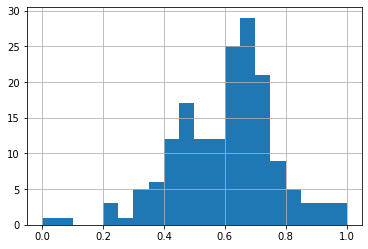

In [25]:
# How's the distribution look?
clubs.n_quality.hist(bins=20);